In [1]:
import pandas as pd
import numpy as np

from os.path import exists
from os import mkdir

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import open3d as o3d
from utils import *

#%env OPEN3D_CPU_RENDERING true

mpl.rcParams["figure.dpi"] = 300
mpl.rcParams["legend.fontsize"] = 12
mpl.rcParams["font.size"] = 12

PLOTDIR = "plots"
DATADIR = "data"

DIRS = [PLOTDIR, DATADIR]

def plot_savepath(filename):
    return PLOTDIR + f"/{filename}"

def data_path(filename):
    return DATADIR + f"/{filename}"

for d in DIRS:
    if not exists(d):
        mkdir(d)
              
output_dir = f"figures/experiments/"

In [2]:
# reading organoid data
Organoid_Names = ['VOL_1857_3.xls',
                  'VOL_1857_2.xls', 
                  'VOL_1857_1.xls',]

organoid_pts = []

for name in Organoid_Names:
    df = pd.read_excel(data_path(name), header = None, skiprows =1)
    df = df.rename(columns = df.iloc[0]).drop(df.index[0])
    df_drop = df.drop(columns=['Unit', 'Category', 'Collection', 'Time', 'ID'])
    pts = df_drop.to_numpy()
    organoid_pts.append(pts)

In [3]:
# reading organoid data
Entity_Names = ['DOTS_1857_3.xls',
                'DOTS_1857_2.xls', 
                'DOTS_1857_1.xls',]

entity_pts = []

for name in Entity_Names:
    df = pd.read_excel(data_path(name), header = None, skiprows =1)
    df = df.rename(columns = df.iloc[0]).drop(df.index[0])
    df_drop = df.drop(columns=['Unit', 'Category', 'Collection', 'Time', 'ID'])
    pts = df_drop.to_numpy()
    entity_pts.append(pts)

In [4]:
assert len(organoid_pts)==len(entity_pts)

In [5]:
distances = []

for index in range(len(organoid_pts)):
    # Organoids
    pcd_org = o3d.geometry.PointCloud()
    pcd_org.points = o3d.utility.Vector3dVector(organoid_pts[index])
    pcd_org.compute_convex_hull()
    pcd_org.estimate_normals()
    pcd_org.orient_normals_consistent_tangent_plane(10)
    
    with o3d.utility.VerbosityContextManager(
            o3d.utility.VerbosityLevel.Debug) as cm:
        mesh_org, densities = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(
            pcd_org, depth=10, scale=10, linear_fit=True)
    # print(mesh)
    mesh_org.paint_uniform_color([0.8, 0.2, 0])
    mesh_org.compute_vertex_normals()
    mesh_org.filter_smooth_simple(number_of_iterations=5)
    
    mesh_to_fill_org = o3d.t.geometry.TriangleMesh.from_legacy(mesh_org)
    mesh_to_fill_org.fill_holes(hole_size=10)
    final_mesh_org = mesh_to_fill_org.to_legacy()
    
    # Entities
    pcd_ent = o3d.geometry.PointCloud()
    pcd_ent.points = o3d.utility.Vector3dVector(entity_pts[index])
    pcd_ent.compute_convex_hull()
    pcd_ent.estimate_normals()
    pcd_ent.orient_normals_consistent_tangent_plane(10)
    
    with o3d.utility.VerbosityContextManager(
            o3d.utility.VerbosityLevel.Debug) as cm:
        mesh_ent, densities = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(
            pcd_ent, depth=10, scale=10, linear_fit=True)
    # print(mesh)
    mesh_ent.paint_uniform_color([0.8, 0.2, 0])
    mesh_ent.compute_vertex_normals()
    mesh_ent.filter_smooth_simple(number_of_iterations=5)
    
    mesh_to_fill_ent = o3d.t.geometry.TriangleMesh.from_legacy(mesh_ent)
    mesh_to_fill_ent.fill_holes(hole_size=10)
    final_mesh_ent = mesh_to_fill_ent.to_legacy()
    
    # Calculation of distances
    mesh_org_toleg = o3d.t.geometry.TriangleMesh.from_legacy(final_mesh_org)
    mesh_ent_toleg = o3d.t.geometry.TriangleMesh.from_legacy(final_mesh_ent)
    
    scene = o3d.t.geometry.RaycastingScene()
    mesh_ids = {}
    mesh_ids[scene.add_triangles(mesh_org_toleg)] = 'surface'
    mesh_ids[scene.add_triangles(mesh_ent_toleg)] = 'cells'

    query_point = np.asarray(entity_pts[index]).astype('float32')

    unsigned_distance = scene.compute_distance(query_point)
    distances.append(unsigned_distance.numpy())

[Open3D DEBUG] Input Points / Samples: 61113 / 22374
[Open3D DEBUG] #   Got kernel density: 0.00740790 (s), 305.246 (MB) / 305.246 (MB) / 371 (MB)
[Open3D DEBUG] #     Got normal field: 0.0390012 (s), 309.352 (MB) / 309.352 (MB) / 371 (MB)
[Open3D DEBUG] Point weight / Estimated Area: 4.575903e-07 / 2.796471e-02
[Open3D DEBUG] #       Finalized tree: 0.0307009 (s), 315.43 (MB) / 315.43 (MB) / 371 (MB)
[Open3D DEBUG] #  Set FEM constraints: 0.0602500 (s), 317.059 (MB) / 317.059 (MB) / 371 (MB)
[Open3D DEBUG] #Set point constraints: 0.00830913 (s), 318.188 (MB) / 318.188 (MB) / 371 (MB)
[Open3D DEBUG] Leaf Nodes / Active Nodes / Ghost Nodes: 201741 / 228160 / 2401
[Open3D DEBUG] Memory Usage: 318.188 MB
[Open3D DEBUG] # Linear system solved: 0.187773 (s), 319.137 (MB) / 319.137 (MB) / 371 (MB)
[Open3D DEBUG] Got average: 0.00473094 (s), 301.367 (MB) / 319.137 (MB) / 371 (MB)
[Open3D DEBUG] Iso-Value: 5.133654e-01 = 3.137330e+04 / 6.111300e+04
[Open3D DEBUG] #          Total Solve:       

In [6]:
dict_keys = (['A', 'B', 'C',])
d = dict(zip(dict_keys, distances))
df = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in d.items() ]))
df = df.melt(var_name = "Entity", value_name = "Distance to Surface (\u03BCm)")

display(df)

,Entity,Distance to Surface (μm)
0,A,12.451331
1,A,0.968251
2,A,5.976069
3,A,5.830978
4,A,11.333537
...,...,...
5368,C,38.519680
5369,C,131.816864
5370,C,118.344337
5371,C,216.497879


In [7]:
df.loc[df['Entity'] == 'A', 'Types'] = 'Repeat 1'  
df.loc[df['Entity'] == 'B', 'Types'] = 'Repeat 2'  
df.loc[df['Entity'] == 'C', 'Types'] = 'Repeat 3'

display(df)

,Entity,Distance to Surface (μm),Types
0,A,12.451331,Repeat 1
1,A,0.968251,Repeat 1
2,A,5.976069,Repeat 1
3,A,5.830978,Repeat 1
4,A,11.333537,Repeat 1
...,...,...,...
5368,C,38.519680,Repeat 3
5369,C,131.816864,Repeat 3
5370,C,118.344337,Repeat 3
5371,C,216.497879,Repeat 3


In [8]:
df['Entity'] = df['Entity'].replace({'A':'1857',
              'B':'1857',
              'C':'1857'}) 

df[np.isfinite(df["Distance to Surface (\u03BCm)"])]
df_final = df[df["Distance to Surface (\u03BCm)"] > 0.0001]

display(df_final)

,Entity,Distance to Surface (μm),Types
0,1857,12.451331,Repeat 1
1,1857,0.968251,Repeat 1
2,1857,5.976069,Repeat 1
3,1857,5.830978,Repeat 1
4,1857,11.333537,Repeat 1
...,...,...,...
5368,1857,38.519680,Repeat 3
5369,1857,131.816864,Repeat 3
5370,1857,118.344337,Repeat 3
5371,1857,216.497879,Repeat 3


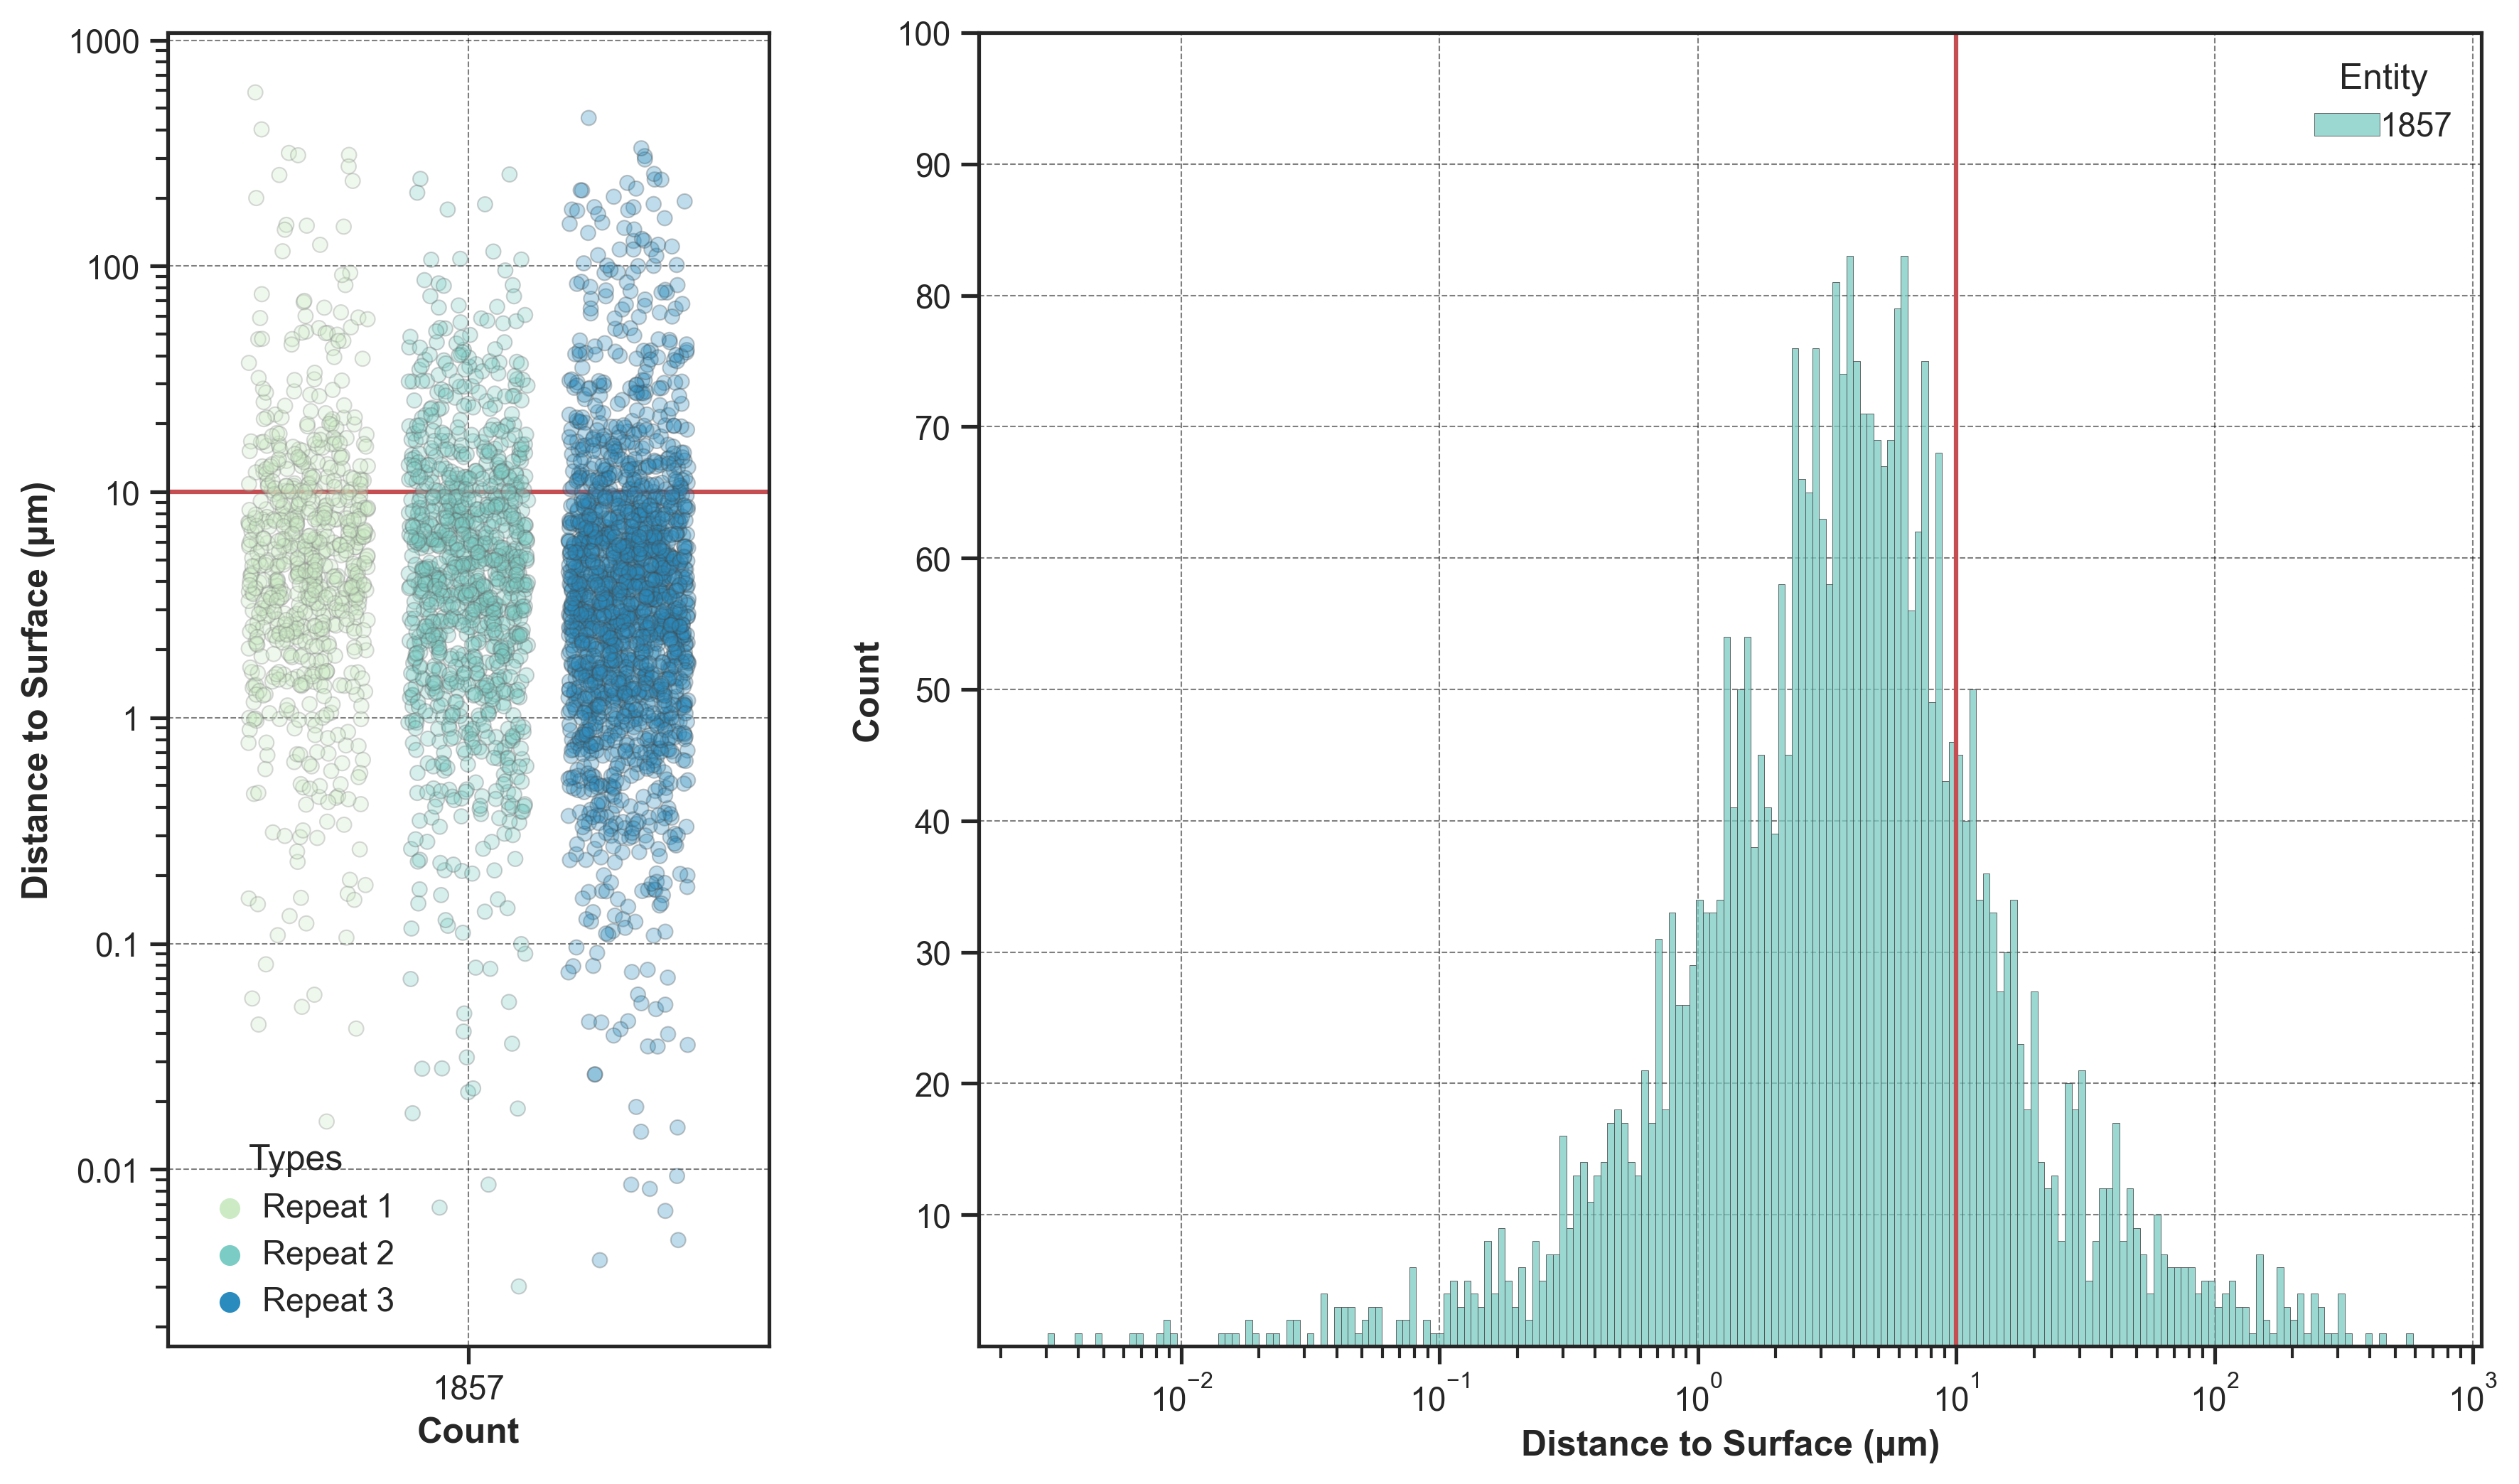

In [9]:
# plotting
sns.set_theme(style="ticks")
fig, axes = plt.subplots(1, 2, figsize=(14, 8), gridspec_kw={'width_ratios': [1, 2.5]})
g = sns.stripplot(ax=axes[0], data=df_final,
              x="Entity", y="Distance to Surface (\u03BCm)",
              hue="Types", palette="GnBu", linewidth=0.5,
              size=5, alpha=0.3, jitter=.30, dodge=True,
                 )

g.set_yscale("log")
# the non-logarithmic labels you want
ticks = [0.01, 0.1, 1, 10, 100, 1000]
g.set_yticks(ticks)
g.set_yticklabels(ticks)
axes[0].grid(color='black', alpha=0.5, linestyle='dashed', linewidth=0.5)
axes[0].set_xlabel('Count', fontweight ='bold')
axes[0].set_ylabel('Distance to Surface (\u03BCm)', fontweight ='bold')

sns.move_legend(
    g, loc="best", ncol=1, frameon=False, columnspacing=5, handletextpad=0
)

g.axhline(10, color='r')

g = sns.histplot(
    df_final,
    x="Distance to Surface (\u03BCm)", hue="Entity",
    bins=200,
    multiple="stack",
    palette="GnBu",
    element="bars",
    edgecolor=".3",
    common_norm=False,
    kde=False,
    pmax=1000,
    linewidth=.2,
    stat="count",
    log_scale=True,
)

# the non-logarithmic labels you want
axes[1].grid(color='black', alpha=0.5, linestyle='dashed', linewidth=0.5)
axes[1].set_xlabel('Distance to Surface (\u03BCm)', fontweight ='bold')
axes[1].set_ylabel('Count', fontweight ='bold')
ticks = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
g.set_yticks(ticks)
g.set_yticklabels(ticks)

sns.move_legend(
    g, loc="best", ncol=1, frameon=False, columnspacing=5, handletextpad=0)

g.axvline(x=10, color='r')

plt.show()

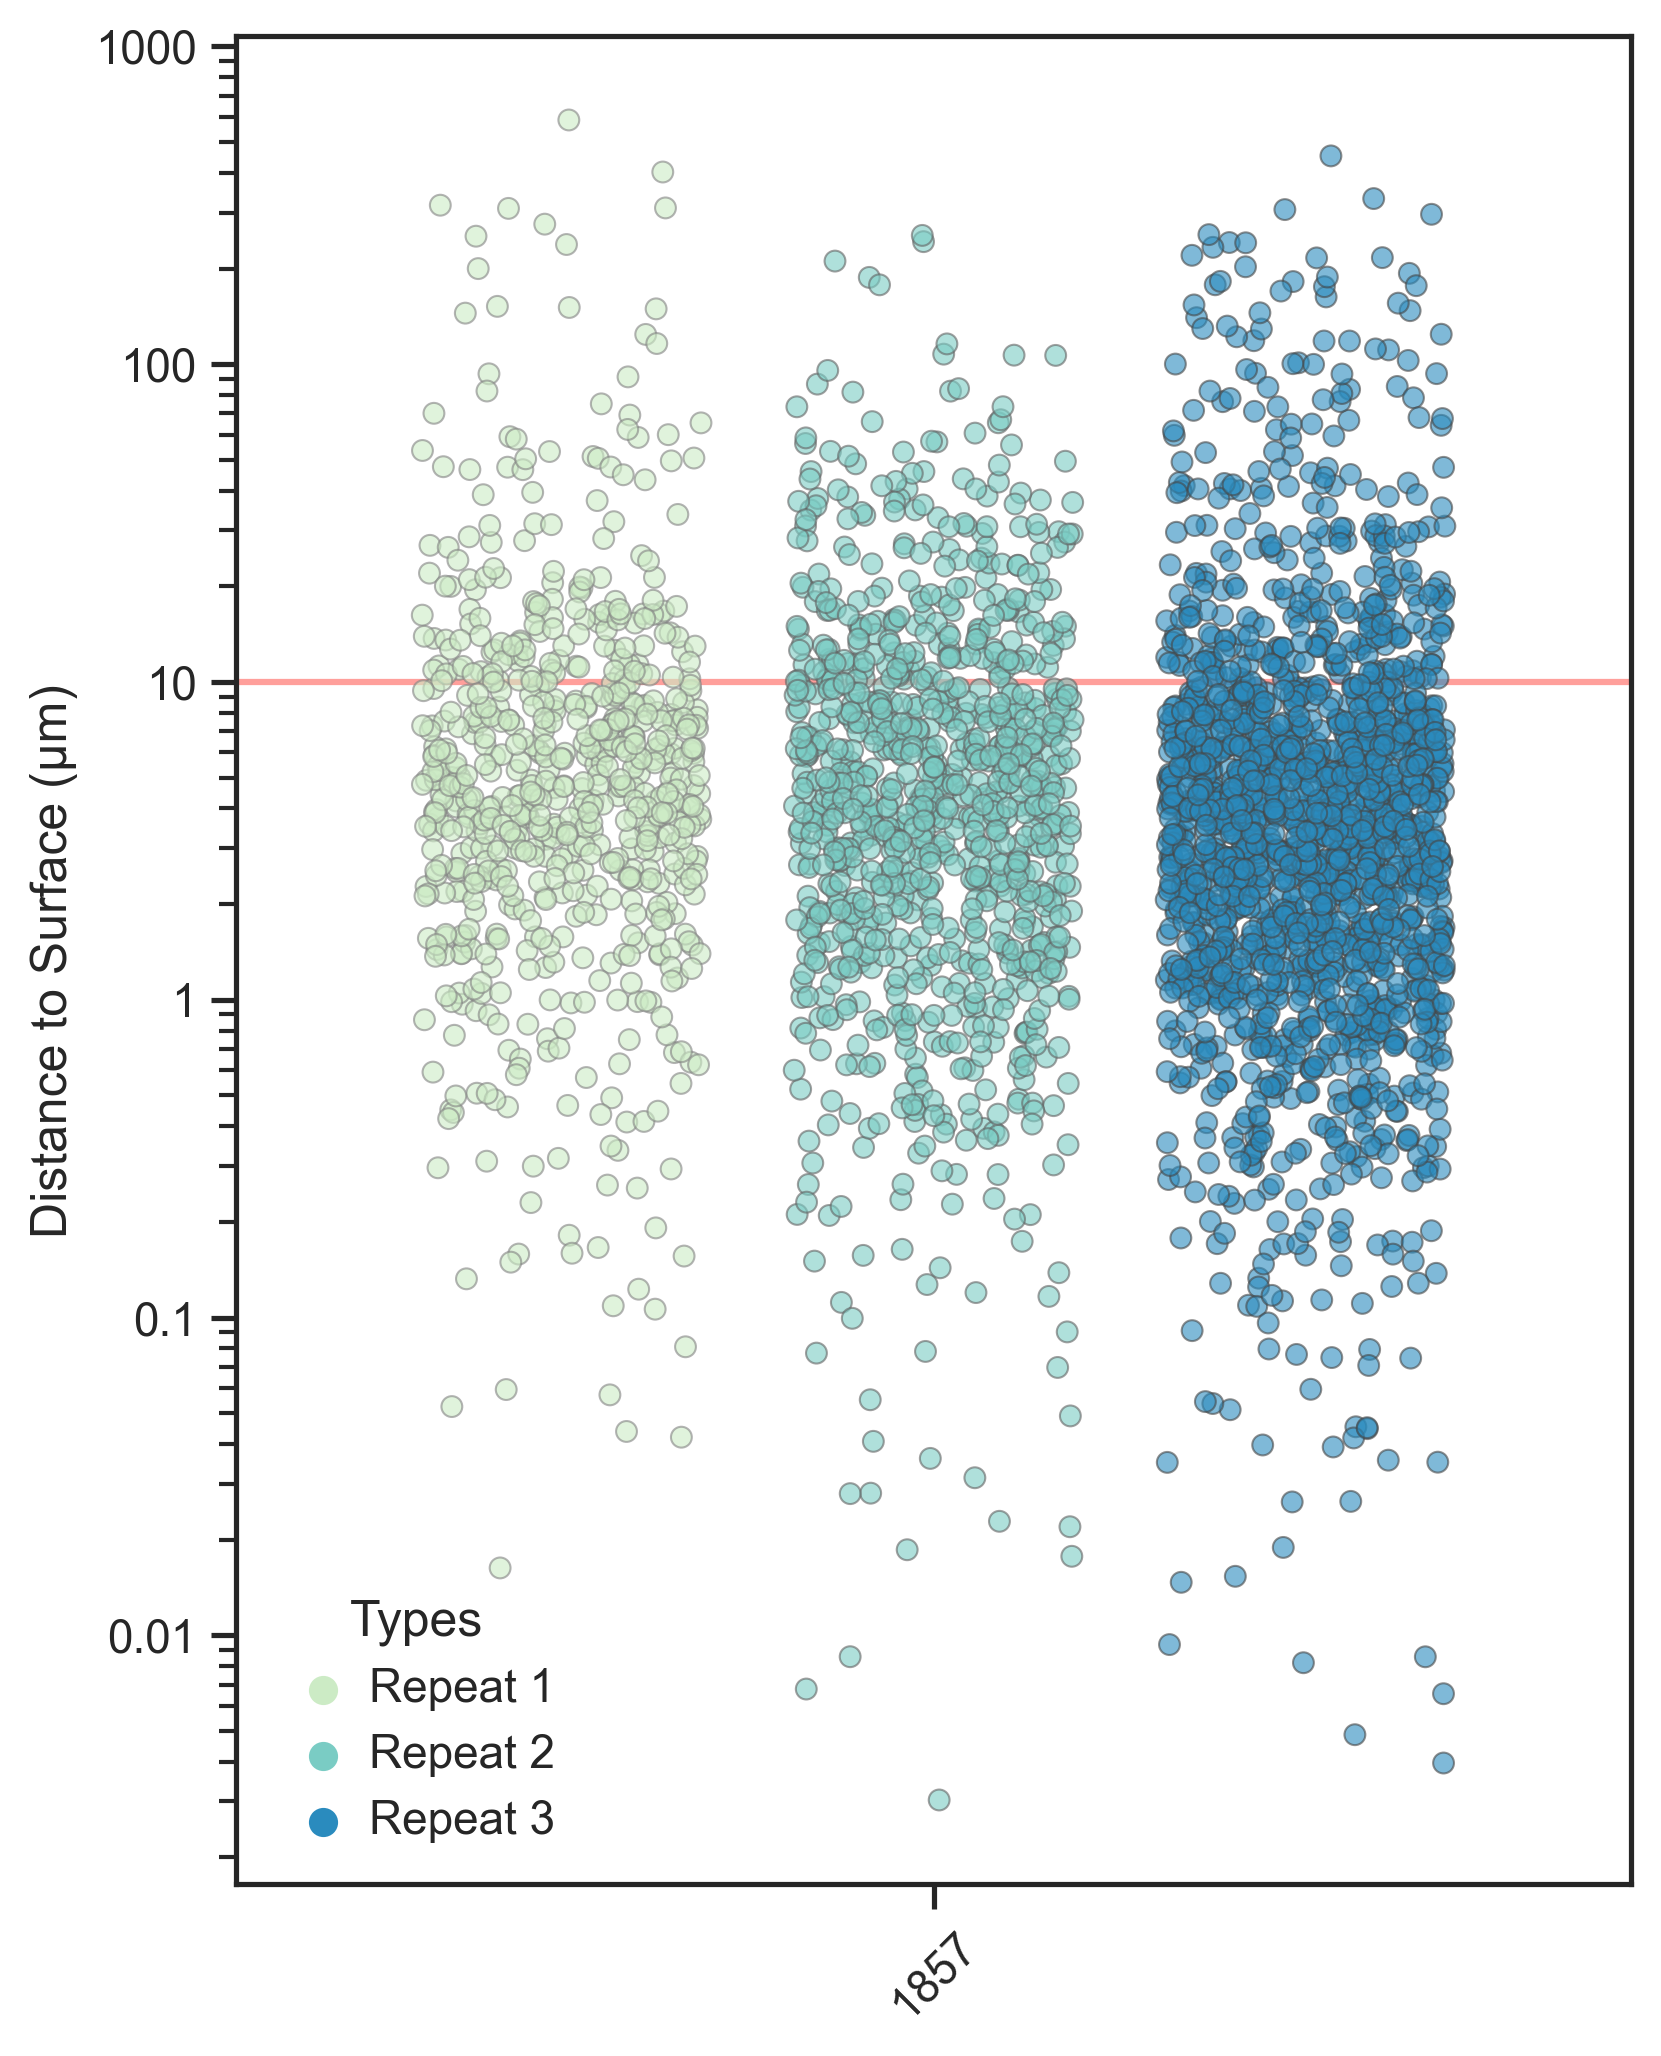

In [10]:
sns.set_theme(style="ticks", palette="pastel")
fig, axes = plt.subplots(1, 1, figsize=(6, 8))
g = sns.stripplot(data=df_final,
              x="Entity", y="Distance to Surface (\u03BCm)",
              hue="Types", palette="GnBu", linewidth=0.5,
              size=5, alpha=0.6, jitter=.30, dodge=True,
                 )
g.set_yscale("log")
# changing to non-logarithmic labels
ticks = [0.01, 0.1, 1, 10, 100, 1000]
g.set_yticks(ticks)
g.set_yticklabels(ticks)


g.axhline(10, color='r')


g.tick_params(axis='x', rotation=45)
g.xaxis.label.set_visible(False)

sns.move_legend(
    g, loc="best", ncol=1, frameon=False, columnspacing=5, handletextpad=0
)

#plt.savefig(plot_savepath('Seaborn_1857.pdf'), bbox_inches='tight')
#plt.savefig(plot_savepath('Seaborn_1857.png'), dpi=300, bbox_inches='tight')
plt.show()